In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statesmodels library
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse,meanabs

#import joblib
import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

In [38]:
from functools import reduce

In [49]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [2]:
data = pd.read_csv("owid-covid-data.csv",index_col='date')

In [3]:
data.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,AFG,Asia,Afghanistan,1.0,1.0,NaN,NaN,NaN,NaN,0.026,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2020-02-25,AFG,Asia,Afghanistan,1.0,0.0,NaN,NaN,NaN,NaN,0.026,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2020-02-26,AFG,Asia,Afghanistan,1.0,0.0,NaN,NaN,NaN,NaN,0.026,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2020-02-27,AFG,Asia,Afghanistan,1.0,0.0,NaN,NaN,NaN,NaN,0.026,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2020-02-28,AFG,Asia,Afghanistan,1.0,0.0,NaN,NaN,NaN,NaN,0.026,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


In [4]:
loc_list = ['United Kingdom','United States','Germany','Canada','Australia']

total_data = data[data['location'].isin(loc_list)]

In [5]:
total_data.shape

(2861, 61)

In [6]:
print("data for Australia: {}".format(total_data.query("location=='Australia'").shape[0]))
print("data for Canada: {}".format(total_data.query("location=='Canada'").shape[0]))
print("data for Germany: {}".format(total_data.query("location=='Germany'").shape[0]))
print("data for United Kingdom: {}".format(total_data.query("location=='United Kingdom'").shape[0]))
print("data for United States: {}".format(total_data.query("location=='United States'").shape[0]))

data for Australia: 572
data for Canada: 572
data for Germany: 574
data for United Kingdom: 567
data for United States: 576


In [7]:
#total_data.columns

In [15]:
cols_to_use = ['date','location','total_cases', 'new_cases','new_cases_smoothed', 'total_deaths', 'new_deaths',
               'new_deaths_smoothed', 'total_cases_per_million','new_cases_per_million', 'new_cases_smoothed_per_million',
               'total_deaths_per_million','new_deaths_per_million','new_deaths_smoothed_per_million','icu_patients',
               'icu_patients_per_million', 'hosp_patients','hosp_patients_per_million', 'weekly_icu_admissions',
               'weekly_icu_admissions_per_million', 'weekly_hosp_admissions','weekly_hosp_admissions_per_million',
               'total_vaccinations','people_vaccinated','people_fully_vaccinated','new_vaccinations', 
               'new_vaccinations_smoothed','total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
               'people_fully_vaccinated_per_hundred', 'hospital_beds_per_thousand']

In [7]:
data_to_analyze = total_data[['location','new_cases']]

data_to_analyze.head()

,location,new_cases
date,,
2020-01-26,Australia,4.0
2020-01-27,Australia,1.0
2020-01-28,Australia,0.0
2020-01-29,Australia,1.0
2020-01-30,Australia,3.0


In [8]:
print("The shape of the dataframe to analyze: {}".format(data_to_analyze.shape))

The shape of the dataframe to analyze: (2861, 2)


In [9]:
data_to_analyze.isnull().sum()/len(data_to_analyze)

location     0.000000
new_cases    0.001398
dtype: float64

In [10]:
data_to_analyze.dropna(axis=0,inplace=True)

In [11]:
data_to_analyze.isnull().sum().any()

False

In [12]:
australia_df = data_to_analyze.query("location=='Australia'")
canada_df = data_to_analyze.query("location=='Canada'")
germany_df = data_to_analyze.query("location=='Germany'")
us_df = data_to_analyze.query("location=='United States'")
uk_df = data_to_analyze.query("location=='United Kingdom'")

In [47]:
#australia_df.head()

In [51]:
#canada_df.head()

In [61]:
#germany_df.head()

In [54]:
#us_df.head()

In [45]:
#uk_df.head()

In [13]:
print(australia_df.shape)
print(canada_df.shape)
print(germany_df.shape)
print(us_df.shape)
print(uk_df.shape)

(572, 2)
(572, 2)
(571, 2)
(575, 2)
(567, 2)


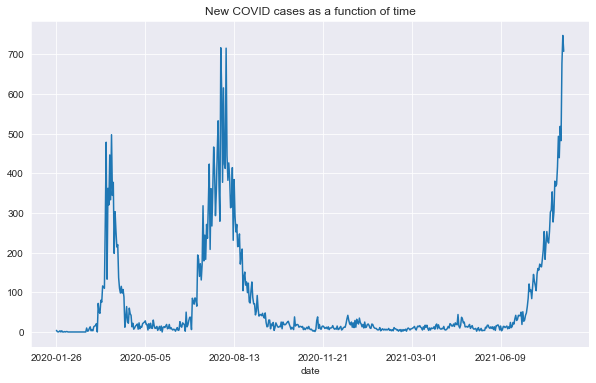

In [14]:
plt.figure(figsize=(10,6))
australia_df['new_cases'].plot(x_compat=True)
plt.title("New COVID cases as a function of time");

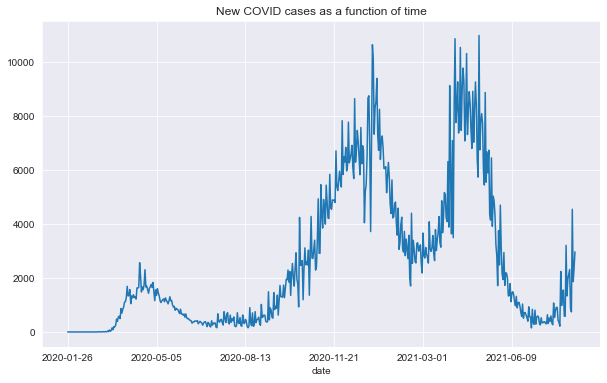

In [15]:
plt.figure(figsize=(10,6))
canada_df['new_cases'].plot(x_compat=True)
plt.title("New COVID cases as a function of time");

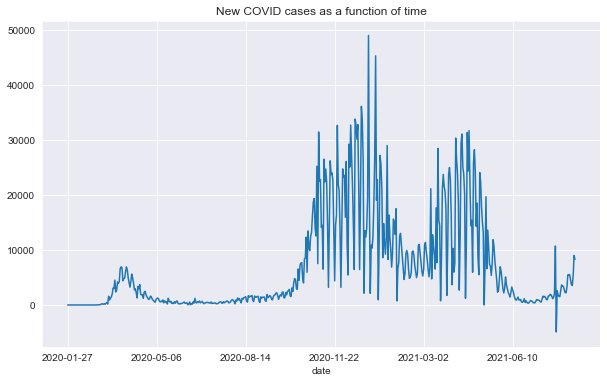

In [16]:
plt.figure(figsize=(10,6))
germany_df['new_cases'].plot(x_compat=True)
plt.title("New COVID cases as a function of time");

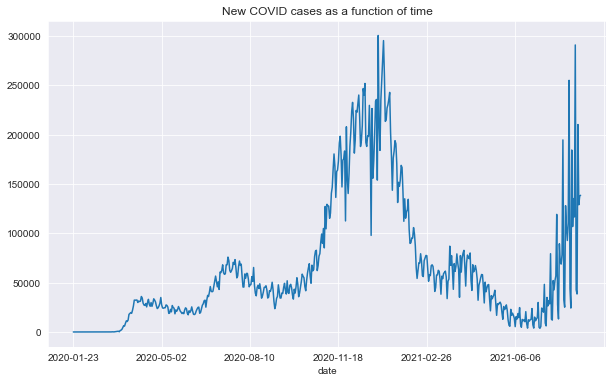

In [17]:
plt.figure(figsize=(10,6))
us_df['new_cases'].plot(x_compat=True)
plt.title("New COVID cases as a function of time");

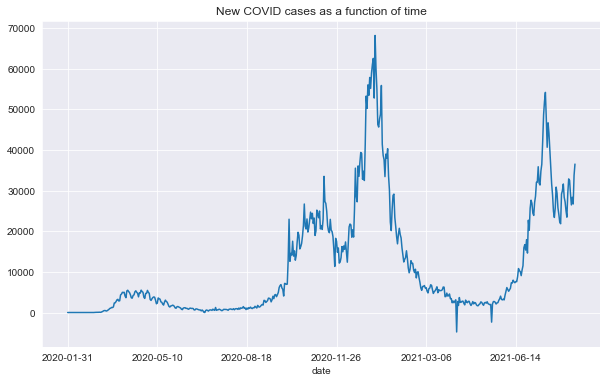

In [18]:
plt.figure(figsize=(10,6))
uk_df['new_cases'].plot(x_compat=True)
plt.title("New COVID cases as a function of time");

In [19]:
#australia_df.isnull().sum()

In [20]:
#canada_df.isnull().sum()

In [21]:
#germany_df.isnull().sum()

In [22]:
#us_df.isnull().sum()

In [23]:
#uk_df.isnull().sum()

In [24]:
#germany_df[germany_df.isnull().any(axis=1)]

In [25]:
#germany_df.dropna(axis=0,inplace=True)

In [26]:
#us_df.dropna(axis=0,inplace=True)

In [27]:
#pd.concat([australia_df,canada_df],axis=1)

In [32]:
australia_df.rename(columns={"new_cases":"aus_new_cases"},inplace=True)
australia_df.drop('location',axis=1,inplace=True)

australia_df.head()

,aus_new_cases
date,
2020-01-26,4.0
2020-01-27,1.0
2020-01-28,0.0
2020-01-29,1.0
2020-01-30,3.0


In [33]:
canada_df.rename(columns={"new_cases":"can_new_cases"},inplace=True)
canada_df.drop('location',axis=1,inplace=True)

germany_df.rename(columns={"new_cases":"ger_new_cases"},inplace=True)
germany_df.drop('location',axis=1,inplace=True)

uk_df.rename(columns={"new_cases":"uk_new_cases"},inplace=True)
uk_df.drop('location',axis=1,inplace=True)

us_df.rename(columns={"new_cases":"us_new_cases"},inplace=True)
us_df.drop('location',axis=1,inplace=True)

In [40]:
dfs = [australia_df,canada_df,germany_df,uk_df,us_df]
        
final_df = reduce(lambda left,right:pd.merge(left,right,how='outer',left_index=True,right_index=True),dfs)        

In [46]:
#final_df.head(10)

In [48]:
final_df.fillna(value=0,inplace=True)

In [75]:
final_df.columns

Index(['aus_new_cases', 'can_new_cases', 'ger_new_cases', 'uk_new_cases',
       'us_new_cases'],
      dtype='object')

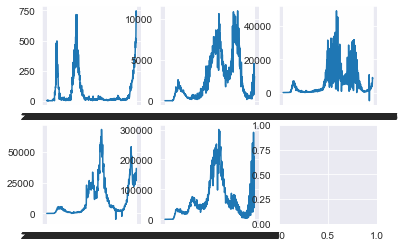

In [79]:
fig,axes = plt.subplots(2,3)

for i,ax in enumerate(axes.flatten()[:-1]):
    data = final_df[final_df.columns[i]]
    ax.plot(data)

In [81]:
# stationarity check

ad_fuller_1 = adfuller(final_df['aus_new_cases'].diff()[1:])
print("Australia")
print("p-value: {}".format(ad_fuller_1[1]))

ad_fuller_2 = adfuller(final_df['can_new_cases'].diff()[1:])
print("Canada")
print("p-value: {}".format(ad_fuller_2[1]))

ad_fuller_3 = adfuller(final_df['ger_new_cases'].diff()[1:])
print("Germany")
print("p-value: {}".format(ad_fuller_3[1]))

ad_fuller_4 = adfuller(final_df['uk_new_cases'].diff()[1:])
print("UK")
print("p-value: {}".format(ad_fuller_4[1]))

ad_fuller_5 = adfuller(final_df['us_new_cases'].diff()[1:])
print("US")
print("p-value: {}".format(ad_fuller_5[1]))

Australia
p-value: 0.02601862936163971
Canada
p-value: 0.06994661294809082
Germany
p-value: 0.20525409579658682
UK
p-value: 0.1725087311035634
US
p-value: 0.4034539447271775


In [83]:
from statsmodels.tsa.stattools import grangercausalitytests

In [85]:
# correlation check

gran_1 = grangercausalitytests(final_df[['aus_new_cases','can_new_cases']],8)

#gran_2 = grangercausalitytests(final_df[['aus_new_cases','ger_new_cases']],4)

#gran_3 = grangercausalitytests(final_df[['aus_new_cases','uk_new_cases']],4)

#gran_4 = grangercausalitytests(final_df[['aus_new_cases','us_new_cases']],4)





Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0361  , p=0.1541  , df_denom=571, df_num=1
ssr based chi2 test:   chi2=2.0468  , p=0.1525  , df=1
likelihood ratio test: chi2=2.0432  , p=0.1529  , df=1
parameter F test:         F=2.0361  , p=0.1541  , df_denom=571, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5668  , p=0.5677  , df_denom=568, df_num=2
ssr based chi2 test:   chi2=1.1435  , p=0.5645  , df=2
likelihood ratio test: chi2=1.1424  , p=0.5649  , df=2
parameter F test:         F=0.5668  , p=0.5677  , df_denom=568, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3972  , p=0.7550  , df_denom=565, df_num=3
ssr based chi2 test:   chi2=1.2065  , p=0.7514  , df=3
likelihood ratio test: chi2=1.2052  , p=0.7517  , df=3
parameter F test:         F=0.3972  , p=0.7550  , df_denom=565, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4063  , p=0.8042  

In [88]:
from statsmodels.tsa.api import VAR

In [89]:
final_df.shape

(575, 5)

In [90]:
train_df = final_df[:-30]
test_df = final_df[-30:]

print(train_df.shape)
print(test_df.shape)

(545, 5)
(30, 5)


In [93]:
model = VAR(train_df.diff()[:1])

In [98]:
#sorted_order = model.select_order()
#print(sorted_order.summary())

In [99]:
var_model = VARMAX(train_df,order=(3,0),enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                                            Statespace Model Results                                                           
Dep. Variable:     ['aus_new_cases', 'can_new_cases', 'ger_new_cases', 'uk_new_cases', 'us_new_cases']   No. Observations:                  545
Model:                                                                                          VAR(3)   Log Likelihood              -26288.028
                                                                                           + intercept   AIC                          52766.055
Date:                                                                                 Sat, 21 Aug 2021   BIC                          53174.630
Time:                                                                                         09:53:42   HQIC                         52925.783
Sample:                                                                                     01-23-2020                                  

In [102]:
n_forecast = 30

start = len(train_df)
end = start + n_forecast

predict = fitted_model.get_prediction(start=start,end=end)

predictions = predict.predicted_mean

In [119]:
#predictions.index

predictions.rename(columns={'aus_new_cases':'aus_new_cases_pred',
                            'can_new_cases':'can_new_cases_pred',
                            'ger_new_cases':'ger_new_cases_pred',
                            'us_new_cases':'us_new_cases_pred',
                            'uk_new_cases':'uk_new_cases_pred'},inplace=True)

In [115]:
test_df.index = pd.to_datetime(test_df.index)

In [116]:
test_df.index

DatetimeIndex(['2021-07-21', '2021-07-22', '2021-07-23', '2021-07-24',
               '2021-07-25', '2021-07-26', '2021-07-27', '2021-07-28',
               '2021-07-29', '2021-07-30', '2021-07-31', '2021-08-01',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-07', '2021-08-08', '2021-08-09',
               '2021-08-10', '2021-08-11', '2021-08-12', '2021-08-13',
               '2021-08-14', '2021-08-15', '2021-08-16', '2021-08-17',
               '2021-08-18', '2021-08-19'],
              dtype='datetime64[ns]', name='date', freq=None)

<AxesSubplot:>

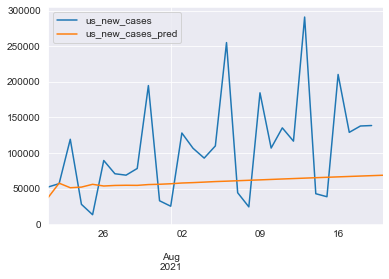

In [125]:
true_vs_preds = pd.concat([test_df,predictions],axis=1)
true_vs_preds[['us_new_cases','us_new_cases_pred']].plot()

In [52]:
auto_arima(final_df['aus_new_cases'],seasonal=True,m=7)

ARIMA(order=(2, 0, 3), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True, with_intercept=False)

In [53]:
australia_df.head()

,aus_new_cases
date,
2020-01-26,4.0
2020-01-27,1.0
2020-01-28,0.0
2020-01-29,1.0
2020-01-30,3.0


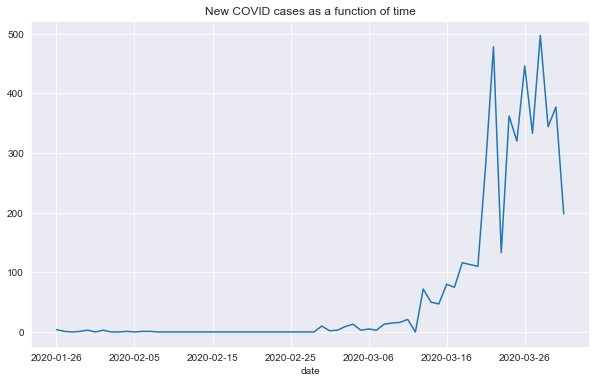

In [55]:
plt.figure(figsize=(10,6))
australia_df['aus_new_cases'].loc['2020-01-26':'2020-03-31'].plot(x_compat=True)
plt.title("New COVID cases as a function of time");

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [60]:
australia_df.index = pd.to_datetime(australia_df.index)
australia_df.index

DatetimeIndex(['2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04',
               ...
               '2021-08-10', '2021-08-11', '2021-08-12', '2021-08-13',
               '2021-08-14', '2021-08-15', '2021-08-16', '2021-08-17',
               '2021-08-18', '2021-08-19'],
              dtype='datetime64[ns]', name='date', length=572, freq=None)

<Figure size 864x720 with 0 Axes>

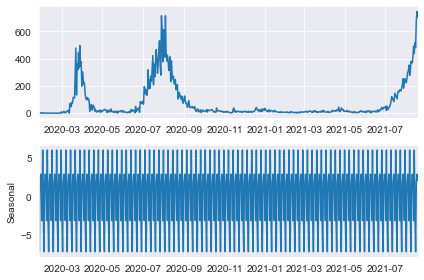

In [66]:
plt.figure(figsize=(12,10))
result = seasonal_decompose(australia_df)
result.plot(trend=False,resid=False);

<Figure size 864x720 with 0 Axes>

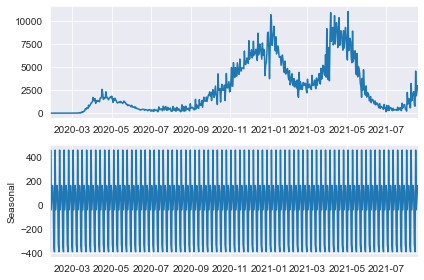

In [67]:
canada_df.index = pd.to_datetime(canada_df.index)

plt.figure(figsize=(12,10))
result = seasonal_decompose(canada_df)
result.plot(trend=False,resid=False);

In [68]:
from statsmodels.tsa.stattools import adfuller

In [69]:
adfuller(final_df['aus_new_cases'], autolag='AIC')

(-1.2869142667586488,
 0.6351375862774519,
 18,
 556,
 {'1%': -3.4421660928041633,
  '5%': -2.8667523104859627,
  '10%': -2.56954599309042},
 5643.905371149839)

In [73]:
adfuller(final_df['aus_new_cases'].diff()[1:], autolag='AIC')

(-3.107286552104326,
 0.02601862936163971,
 19,
 554,
 {'1%': -3.4422089502693454,
  '5%': -2.866771178805824,
  '10%': -2.5695560476482164},
 5630.689352258622)